In [9]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle

# JAX
import jax
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.experimental import stax


# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

#plt.style.use('bmh')

## Helper functions

In [10]:
def plot_samps(draws, columns=4, rows=3, figsize = (19,12), ttl="CAR priors"):
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    _min, _max = np.amin(draws[0:columns*rows]), np.amax(draws[0:columns*rows])
    for r in range(rows):
        for c in range(columns):
            im = axs[r, c].imshow(draws[r*columns + c].reshape(ny, nx), 
                                  cmap='viridis', interpolation='none', #extent=[0,1,0,1], 
                                  origin='lower')
                                  #,vmin=_min, vmax=_max)
            axs[r, c].set_title("draw "+str(r*columns + c))  
            fig.colorbar(im, ax=axs[r, c])
    fig.suptitle(ttl, fontsize=16)
    plt.show()
    
def plot_truth_estimate(y_true, mean_post_pred_vae, ttl1="Ground truth", ttl2="CAR estimate"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    _min, _max = np.amin([y_true, mean_post_pred_vae]), np.amax([y_true, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(ny, nx), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_vae.reshape(ny, nx), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2) 
    
def plot_truth_car_vae(y_true, mean_post_pred_car, mean_post_pred_vae, 
                       ttl1="Ground truth", ttl2="CAR estimate", ttl3="VAE estimate"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    _min = np.amin([y_true, mean_post_pred_car, mean_post_pred_vae])
    _max = np.amax([y_true, mean_post_pred_car, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(ny, nx), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_car.reshape(ny, nx), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2)
    
    im = axs[2].imshow(mean_post_pred_vae.reshape(ny, nx), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[2])
    axs[2].set_title(ttl3)

## Cimluate data based on the CAR model

In [11]:
# create grid
k = 1
nx = 15 * k
ny = 10 * k

pols = [] # list of polygons

for j in range(ny):
    for i in range(nx):
        coords = [(i,j), (i+1, j), (i+1, j+1), (i, j+1), (i,j)]
        p = Polygon(coords)
        pols.append(p)
    
N = len(pols)

# adjacency matrix
A = np.zeros(shape=(N,N))

for i in range(N):
    for j in range(i+1,N):
        if (pols[i].intersection(pols[j]).length > 0):
            A[i,j] = 1
            A[j,i] = 1

# number of neighbours
d = A.sum(axis=0)

#print(A)
#print(d)
print(N)

150


In [12]:
D = jnp.diag(d)
np.linalg.det(np.linalg.inv(D - A))

0.0

In [13]:
def CAR(args):
    
    A = args["A"]
    d = args["d"]
    D = jnp.diag(d)

    #alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.999))
    alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
    
    Q = (D - alpha * A)
    
    car = numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q))
    

In [14]:
args = {# data
        "d": d,
        "A":A,
        "rng_key": random.PRNGKey(0),
        "batch_size": 100
}

In [15]:
# CAR: prior predictive

rng_key = args["rng_key"]
rng_key, rng_key_ = random.split(rng_key)

car_predictive = Predictive(CAR, num_samples=args["batch_size"])
car_preds = car_predictive(rng_key_, args)
car_draws = car_preds['car']

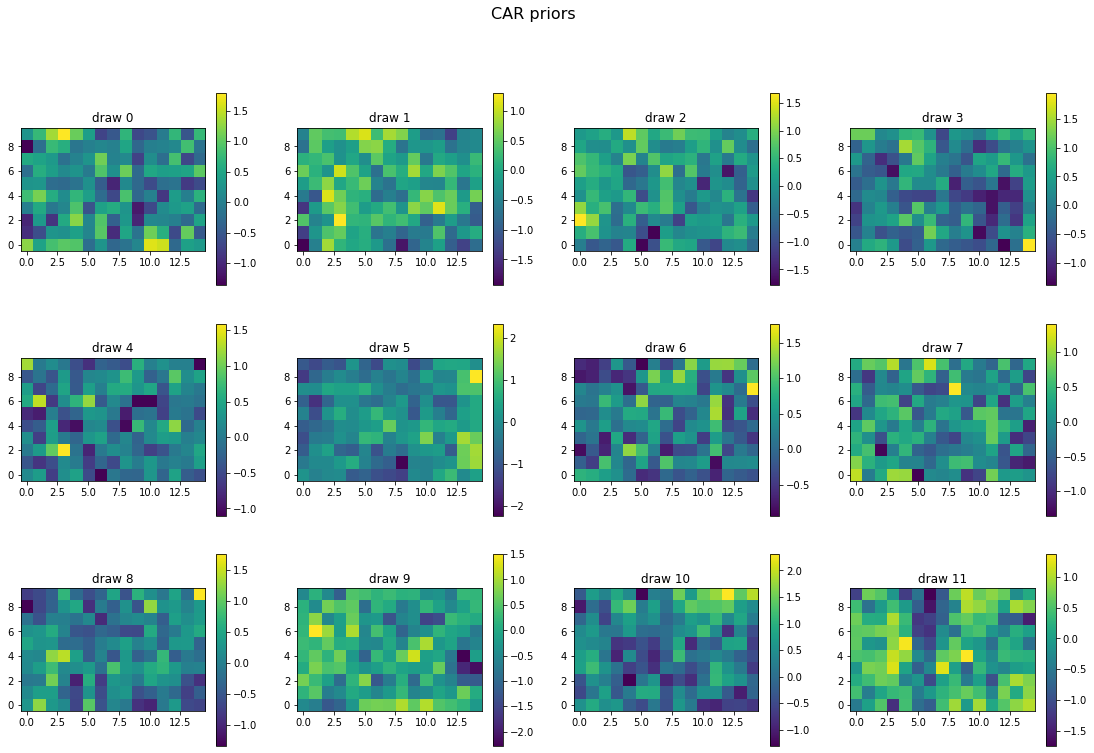

In [16]:
plot_samps(car_draws)

## Train VAE

In [17]:
args = {# data
        "d": d,
        "A":A,
        "rng_key": random.PRNGKey(0),
    
        # VAE training
        "num_epochs": 300, 
        "learning_rate": 1.0e-3, 
        "batch_size": 100, 
        "hidden_dim": 130,
        "z_dim": 130, 
        "num_train": 100,
        "num_test":100,
}

In [18]:
def vae_encoder(hidden_dim, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Elu,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()), # mean
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp), # std -- i.e. diagonal covariance
        ),
    )


def vae_decoder( hidden_dim, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Elu,
        stax.Dense(out_dim, W_init=stax.randn())
    )

def vae_model(batch, hidden_dim, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", vae_decoder( hidden_dim, out_dim), (batch_dim, z_dim))
    z = numpyro.sample("z", dist.Normal(jnp.zeros((z_dim,)), jnp.ones((z_dim,))))
    gen_loc = decode(z)    
    numpyro.sample("obs", dist.Normal(gen_loc, .05), obs=batch) 
    #return 
    

def vae_guide(batch, hidden_dim,  z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", vae_encoder(hidden_dim, z_dim), (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    z = numpyro.sample("z", dist.Normal(z_loc, z_std))
    return z

@jit
def epoch_train(rng_key, svi_state, num_train):

    def body_fn(i, val):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        loss_sum, svi_state = val # val -- svi_state
        batch = car_predictive(rng_key_i, args)['car']
        svi_state, loss = svi.update(svi_state, batch) 
        loss_sum += loss / args['batch_size']
        return loss_sum, svi_state

    return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state)) #fori_loop(lower, upper, body_fun, init_val)

@jit
def eval_test(rng_key, svi_state, num_test):

    def body_fn(i, loss_sum):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        batch = car_predictive(rng_key_i, args)['car']
        loss = svi.evaluate(svi_state, batch) / args['batch_size']
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fn, 0.0)
    loss = loss / num_test

    return loss

adam = optim.Adam(step_size=args["learning_rate"])

#svi = SVI(vae_model, vae_guide, adam, RenyiELBO(alpha=-1, num_particles=4), 
svi = SVI(vae_model, vae_guide, adam, RenyiELBO(), 
          hidden_dim=args["hidden_dim"], 
          z_dim=args["z_dim"])

rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
init_batch = car_predictive(rng_key_, args)['car']
svi_state = svi.init(rng_key_init, init_batch)

In [19]:
test_loss_list = []

for i in range(args['num_epochs']):
    
    rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
    
    t_start = time.time()

    num_train = 1000
    _, svi_state = epoch_train(rng_key_train, svi_state, num_train)

    num_test = 1000
    test_loss = eval_test(rng_key_test, svi_state, num_test)
    test_loss_list += [test_loss]

    print("Epoch {}: loss = {} ({:.2f} s.)".format(i, test_loss, time.time() - t_start))
    
    if math.isnan(test_loss): break

Epoch 0: loss = 5634.044921875 (9.07 s.)
Epoch 1: loss = 4273.1806640625 (0.00 s.)
Epoch 2: loss = 3583.61572265625 (0.00 s.)
Epoch 3: loss = 3228.06787109375 (0.00 s.)
Epoch 4: loss = 2969.5390625 (0.00 s.)
Epoch 5: loss = 2768.38232421875 (0.00 s.)
Epoch 6: loss = 2604.810546875 (0.00 s.)
Epoch 7: loss = 2497.6728515625 (0.00 s.)
Epoch 8: loss = 2448.412353515625 (0.00 s.)
Epoch 9: loss = 2348.6259765625 (0.00 s.)
Epoch 10: loss = 2285.0146484375 (0.00 s.)
Epoch 11: loss = 2200.13330078125 (0.00 s.)
Epoch 12: loss = 2188.08837890625 (0.00 s.)
Epoch 13: loss = 2136.335205078125 (0.00 s.)
Epoch 14: loss = 2101.2724609375 (0.00 s.)
Epoch 15: loss = 2048.6650390625 (0.00 s.)
Epoch 16: loss = 2069.21337890625 (0.00 s.)
Epoch 17: loss = 2044.8092041015625 (0.00 s.)
Epoch 18: loss = 2000.8817138671875 (0.00 s.)
Epoch 19: loss = 1989.5694580078125 (0.00 s.)
Epoch 20: loss = 1951.499267578125 (0.00 s.)
Epoch 21: loss = 1960.5921630859375 (0.00 s.)
Epoch 22: loss = 1949.568603515625 (0.00 s.)


Epoch 182: loss = 1277.1546630859375 (0.00 s.)
Epoch 183: loss = 1271.095947265625 (0.00 s.)
Epoch 184: loss = 1279.5601806640625 (0.00 s.)
Epoch 185: loss = 1280.3123779296875 (0.00 s.)
Epoch 186: loss = 1276.583740234375 (0.00 s.)
Epoch 187: loss = 1274.96240234375 (0.00 s.)
Epoch 188: loss = 1274.767822265625 (0.00 s.)
Epoch 189: loss = 1275.06201171875 (0.00 s.)
Epoch 190: loss = 1282.250732421875 (0.00 s.)
Epoch 191: loss = 1273.04345703125 (0.00 s.)
Epoch 192: loss = 1271.357177734375 (0.00 s.)
Epoch 193: loss = 1279.0694580078125 (0.00 s.)
Epoch 194: loss = 1270.689697265625 (0.00 s.)
Epoch 195: loss = 1270.0933837890625 (0.00 s.)
Epoch 196: loss = 1279.171142578125 (0.00 s.)
Epoch 197: loss = 1277.78466796875 (0.00 s.)
Epoch 198: loss = 1278.245849609375 (0.00 s.)
Epoch 199: loss = 1278.647216796875 (0.00 s.)
Epoch 200: loss = 1276.016357421875 (0.00 s.)
Epoch 201: loss = 1275.2967529296875 (0.00 s.)
Epoch 202: loss = 1272.427978515625 (0.00 s.)
Epoch 203: loss = 1276.553466796

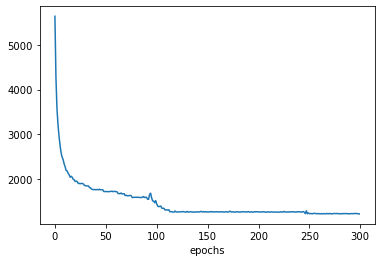

In [20]:
plt.figure()
plt.plot(np.arange(0, len(test_loss_list), 1), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.show()

In [21]:
decoder_params = svi.get_params(svi_state)["decoder$params"]
args["decoder_params"] = decoder_params

In [22]:
# Save after training
#with open('decoders/decoder_car_sim', 'wb') as file:
#    pickle.dump(decoder_params, file)

In [23]:
# Load 
#with open('../decoders/decoder_car_sim', 'rb') as file:
#    decoder_params = pickle.load(file)
#    print(len(decoder_params))

#args["decoder_params"] = decoder_params

## Plot what VAE has learnt

In [24]:
decoder_params = args["decoder_params"] 
z_dim, hidden_dim = decoder_params[0][0].shape
    
decoder_nn = vae_decoder(hidden_dim, N)  

# check output of the decoder
for i in range(10):
    z = jnp.ones(z_dim) + i
    print(decoder_nn[1](decoder_params, z)[0:4])

[-0.67465043 -0.31698686 -0.93045545 -1.2586647 ]
[-1.1607877 -0.6851652 -1.9321165 -2.2778022]
[-1.4917748 -1.0985749 -2.9038036 -3.0696547]
[-1.7153201 -1.536747  -3.8144243 -3.7189057]
[-1.8854735 -1.9842002 -4.6707172 -4.2823997]
[-2.0248349 -2.4335902 -5.480474  -4.795073 ]
[-2.1454961 -2.882787  -6.250515  -5.27703  ]
[-2.2547746 -3.3305078 -6.988548  -5.739807 ]
[-2.3569326 -3.7760715 -7.7006702 -6.190615 ]
[-2.455011  -4.2192144 -8.392093  -6.6339235]


In [25]:
def vae_sample(args):
    
    decoder_params = args["decoder_params"] 
    z_dim, hidden_dim = decoder_params[0][0].shape
    
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder( hidden_dim, N)  
    car = numpyro.deterministic("car", decoder_nn[1](decoder_params, z)) 

In [26]:
rng_key, rng_key_predict = random.split(random.PRNGKey(2))
vae_predictive = Predictive(vae_sample, num_samples=12)
vae_draws = vae_predictive(rng_key_predict, args)['car']

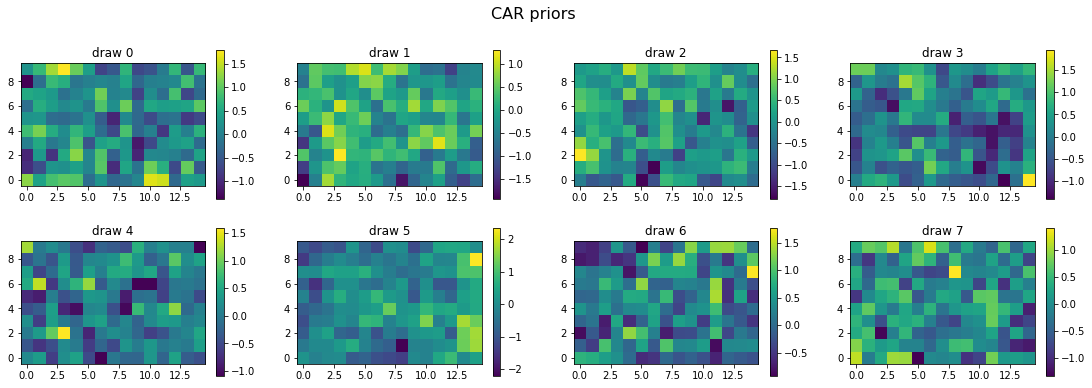

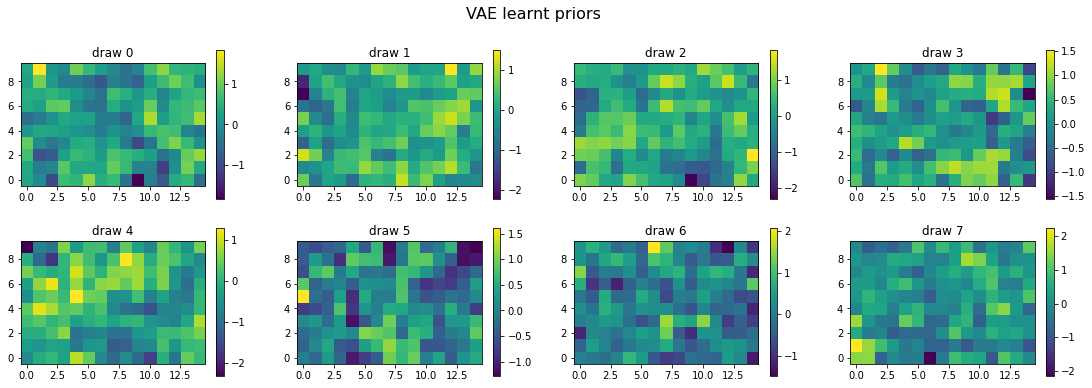

In [27]:
plot_samps(car_draws, columns=4, rows=2, figsize = (19, 6))
plot_samps(vae_draws, columns=4, rows=2, figsize = (19, 6), ttl="VAE learnt priors")

In [28]:
#plot_car(car_draws)
#plot_car(vae_draws, ttl="VAE learnt priors")

## Inference on observed data

In [29]:
def CAR_model(args, y=None, alpha=None, noise=None):
    
    A = args["A"]
    d = args["d"]
    D = jnp.diag(d)

    if alpha is None:
        alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
        
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    Q = (D - alpha * A)
    
    car = numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q))
    car_samples = numpyro.deterministic('car_samples', car)
    
    if y is None: # durinig prediction
        numpyro.sample("y_pred", dist.Normal(car, noise))
    else: # during inference
        numpyro.sample("y", dist.Normal(car, noise), obs=y)

In [30]:
# generate ground truth - fix alpha
rng_key, rng_key_truth = random.split(rng_key)
car_predictive = Predictive(CAR_model, num_samples=1)
car_preds = car_predictive(rng_key_truth, args, alpha=0.7, noise=0.5)
y_data = car_preds['y_pred'][0,:]
y_truth = car_preds['car'][0,:]

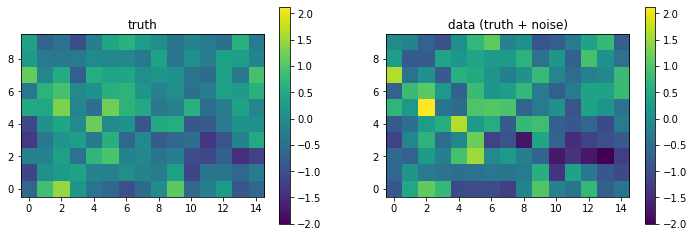

In [31]:
plot_truth_estimate(y_truth, y_data, ttl1="truth", ttl2="data (truth + noise)")

In [32]:
#plt.figure()
#plt.imshow(y_true.reshape(ny, nx)) 
#plt.title("Ground Truth")
#plt.colorbar(shrink = 0.4)
#plt.show() 

## Inference with VAE-CAR

In [33]:
N

150

In [34]:
def VAE_model(args, y=None, noise=None):
    
    decoder_params = args["decoder_params"] 
    z_dim, hidden_dim = decoder_params[0][0].shape
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder( hidden_dim, N)  
    car_vae = numpyro.deterministic("vae_car", decoder_nn[1](decoder_params, z))
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # durinig prediction
        numpyro.sample("y_pred", dist.Normal(car_vae, noise))
    else: # during inference
        numpyro.sample("y", dist.Normal(car_vae, noise), obs=y)

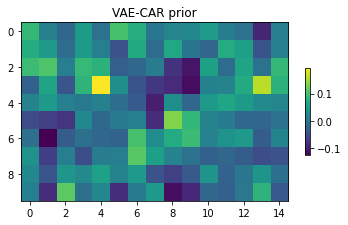

In [35]:
# VAE-CAR: prior predictive
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(VAE_model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, args)
pred_obs = prior_predictions['vae_car']
mean_prior_pred_vae = np.mean(pred_obs, axis=0)
hpdi_prior_pred_vae = hpdi(pred_obs, 0.89)

plt.figure()
plt.imshow(mean_prior_pred_vae.reshape(ny, nx)) 
plt.colorbar(shrink=0.4)
plt.title("VAE-CAR prior")
plt.show()

In [36]:
# inference
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(VAE_model, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
rng_key, rng_key_infer = random.split(rng_key)
mcmc.run(rng_key_infer, args, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████████████████████████████████████████| 3000/3000 [00:04<00:00, 727.98it/s, 15 steps of size 3.65e-01. acc. prob=0.87]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       noise      0.53      0.05      0.52      0.45      0.60   1158.87      1.00
  vae_car[0]     -0.67      0.45     -0.68     -1.47      0.02   4839.26      1.00
  vae_car[1]      0.34      0.41      0.34     -0.31      1.04   5265.48      1.00
  vae_car[2]      0.69      0.42      0.69     -0.00      1.36   4581.99      1.00
  vae_car[3]      0.41      0.41      0.40     -0.27      1.05   5528.55      1.00
  vae_car[4]     -0.75      0.40     -0.74     -1.38     -0.08   4877.02      1.00
  vae_car[5]     -0.75      0.42     -0.76     -1.41     -0.06   4994.66      1.00
  vae_car[6]     -0.82      0.41     -0.81     -1.47     -0.15   7405.93      1.00
  vae_car[7]     -0.88      0.41     -0.89     -1.56     -0.24   5150.29      1.00
  vae_car[8]     -0.17      0.39     -0.17     -0.80      0.47   4527.08      1.00
  vae_car[9]      0.63      0.42      0.64     -0.08      1.29   4138.75      1.00
 va

In [37]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['vae_car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 7 s
Average ESS for all CAR effects : 4769


In [38]:
mcmc_samples.keys()

dict_keys(['noise', 'vae_car', 'z'])

In [39]:
# posterior predictive
rng_key, rng_key_ = random.split(rng_key)
posterior_predictive = Predictive(VAE_model, mcmc_samples)
posterior_predictions = posterior_predictive(rng_key_, args)
post_obs = posterior_predictions['vae_car']
mean_post_pred_vae = np.mean(post_obs, axis=0)
hpdi_post_pred_vae = hpdi(post_obs, 0.9)

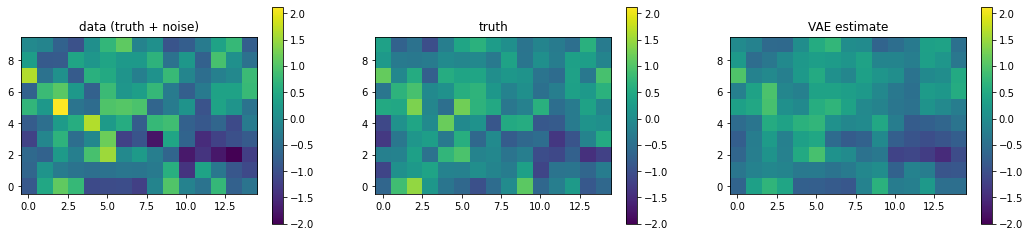

In [40]:
plot_truth_car_vae(y_data, y_truth, mean_post_pred_vae, ttl1="data (truth + noise)", ttl2="truth", ttl3="VAE estimate")

Text(0, 0.5, 'VAE post. predictive')

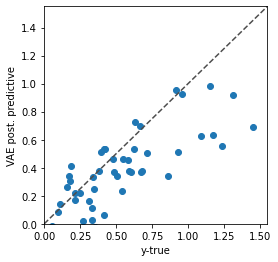

In [41]:
mx = np.max([y_truth, mean_post_pred_vae])
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(y_truth, mean_post_pred_vae)
plt.ylim(0, mx+0.1)
plt.xlim(0, mx+0.1)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("y-true")
plt.ylabel("VAE post. predictive")

In [42]:
MSE_vae = np.mean((y_truth -  mean_post_pred_vae)**2)
print(MSE_vae)

0.13461307


## Inference with CAR

In [43]:
#args["y"] = y_true

# inference - smooth data and infer alpha
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(CAR_model, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
rng_key, rng_key_infer = random.split(rng_key)
mcmc.run(rng_key_infer, args, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|███████████████████████████████████████████████| 3000/3000 [00:44<00:00, 67.60it/s, 15 steps of size 2.96e-01. acc. prob=0.89]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha      0.88      0.07      0.90      0.79      0.99   1884.69      1.00
          car[0]     -0.69      0.35     -0.69     -1.27     -0.12   3177.42      1.00
          car[1]      0.33      0.35      0.33     -0.24      0.88   3030.66      1.00
          car[2]      0.80      0.34      0.81      0.25      1.38   2306.83      1.00
          car[3]      0.48      0.34      0.49     -0.09      1.01   3437.17      1.00
          car[4]     -0.79      0.35     -0.80     -1.41     -0.28   3175.64      1.00
          car[5]     -0.88      0.34     -0.88     -1.41     -0.34   2966.70      1.00
          car[6]     -0.89      0.33     -0.90     -1.39     -0.31   3348.38      1.00
          car[7]     -0.97      0.35     -0.96     -1.58     -0.44   2404.15      1.00
          car[8]     -0.15      0.34     -0.15     -0.72      0.42   4858.64      1.00
          car[9]      0.66      0.34      

In [44]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))



MCMC elapsed time: 47 s
Average ESS for all CAR effects : 3128


In [45]:
mcmc_samples.keys()

dict_keys(['alpha', 'car', 'car_samples', 'noise'])

In [46]:
# posterior predictive
rng_key, rng_key_predict = random.split(rng_key)
posterior_predictive = Predictive(CAR_model, mcmc_samples)
posterior_predictions = posterior_predictive(rng_key_predict, args, y=None)

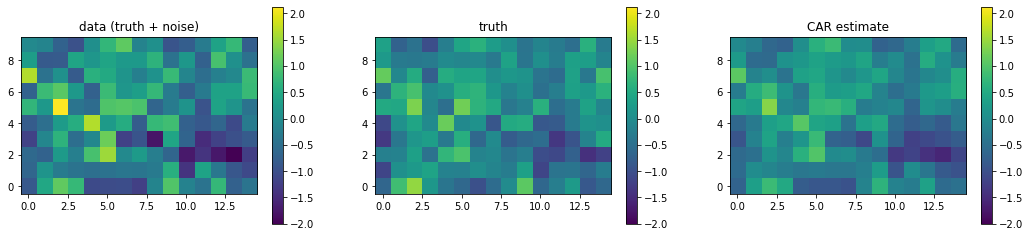

In [48]:
post_obs = posterior_predictions['car_samples']
mean_post_pred_car = np.mean(post_obs, axis=0)
hpdi_post_pred_car = hpdi(post_obs, 0.9)

plot_truth_car_vae(y_data, 
                   y_truth, 
                   mean_post_pred_car, 
                   ttl1="data (truth + noise)", 
                   ttl2="truth", 
                   ttl3="CAR estimate")

0.118769534


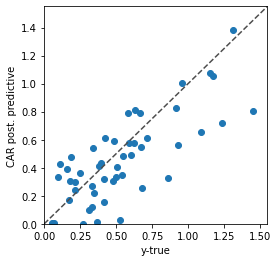

In [49]:
mx = np.max([y_truth, mean_post_pred_car])
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(y_truth, mean_post_pred_car)
plt.ylim(0, mx+0.1)
plt.xlim(0, mx+0.1)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("y-true")
plt.ylabel("CAR post. predictive")

MSE_car = np.mean((y_truth -  mean_post_pred_car)**2)
print(MSE_car)

Text(0, 0.5, 'CAR post. predictive')

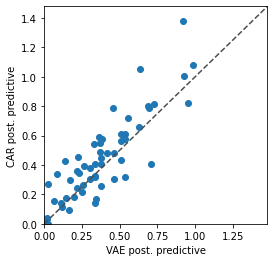

In [50]:
mx = np.max([ mean_post_pred_vae, mean_post_pred_car])
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(mean_post_pred_vae, mean_post_pred_car)
plt.ylim(0, mx+0.1)
plt.xlim(0, mx+0.1)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("VAE post. predictive")
plt.ylabel("CAR post. predictive")

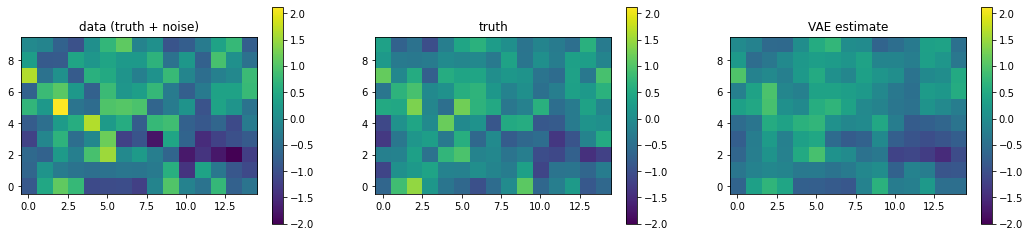

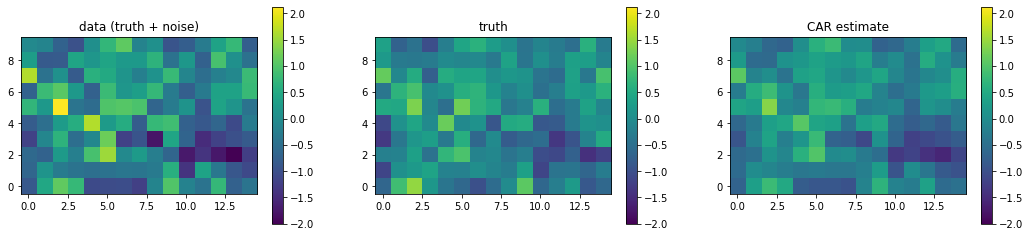

In [55]:
plot_truth_car_vae(y_data, 
                   y_truth, 
                   mean_post_pred_vae, 
                   ttl1="data (truth + noise)", 
                   ttl2="truth", 
                   ttl3="VAE estimate")

plot_truth_car_vae(y_data, 
                   y_truth, 
                   mean_post_pred_car, 
                   ttl1="data (truth + noise)", 
                   ttl2="truth", 
                   ttl3="CAR estimate")

In [56]:
def plot_data_truth_car_vae(y_data, y_true, mean_post_pred_car, mean_post_pred_vae, 
                       ttl1="Data", ttl2="Ground truth", ttl3="CAR estimate", ttl4="VAE-CAR estimate"):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    _min = np.amin([y_data, y_true, mean_post_pred_car, mean_post_pred_vae])
    _max = np.amax([y_data, y_true, mean_post_pred_car, mean_post_pred_vae])

    im = axs[0,0].imshow(y_data.reshape(ny, nx), 
                       cmap='inferno', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0,0])
    axs[0,0].set_title(ttl1)  

    im = axs[0,1].imshow(y_true.reshape(ny, nx), 
                       cmap='inferno', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[0,1])
    axs[0,1].set_title(ttl2)
    
    im = axs[1,0].imshow(mean_post_pred_car.reshape(ny, nx), 
                       cmap='inferno', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1,0])
    axs[1,0].set_title(ttl3)
    
    im = axs[1,1].imshow(mean_post_pred_vae.reshape(ny, nx), 
                       cmap='inferno', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1,1])
    axs[1,1].set_title(ttl4)
    
    return fig

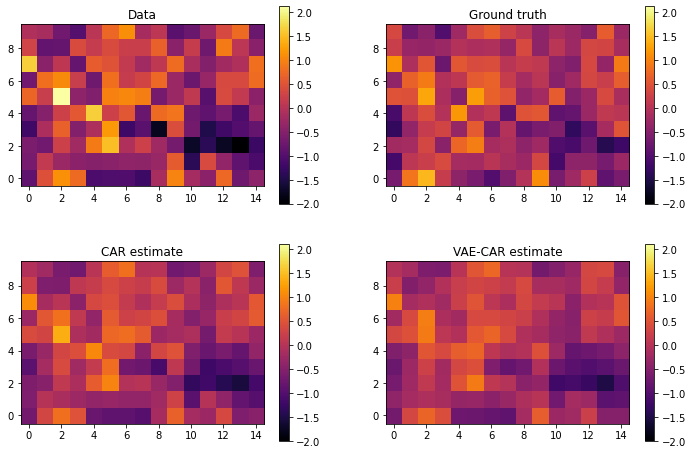

In [57]:
fig = plot_data_truth_car_vae(y_data, 
                        y_truth, 
                        mean_post_pred_car,
                        mean_post_pred_vae)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#fig.savefig("../res/synth_CAR.pdf")